### Digit Recognition Project

In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

### Loading and Exploring Data

In [2]:
labeled_images = np.load("data/labeled_images.npy")
labeled_digits = np.load("data/labeled_digits.npy")
autograder_images = np.load("data/autograder_images.npy")

In [3]:
# This is an array containing all the 3750 images of size 28 times 28 pixels:
labeled_images.shape

(3750, 28, 28)

In [4]:
labeled_digits.shape

(3750,)

Text(0, 0.5, 'Frequency')

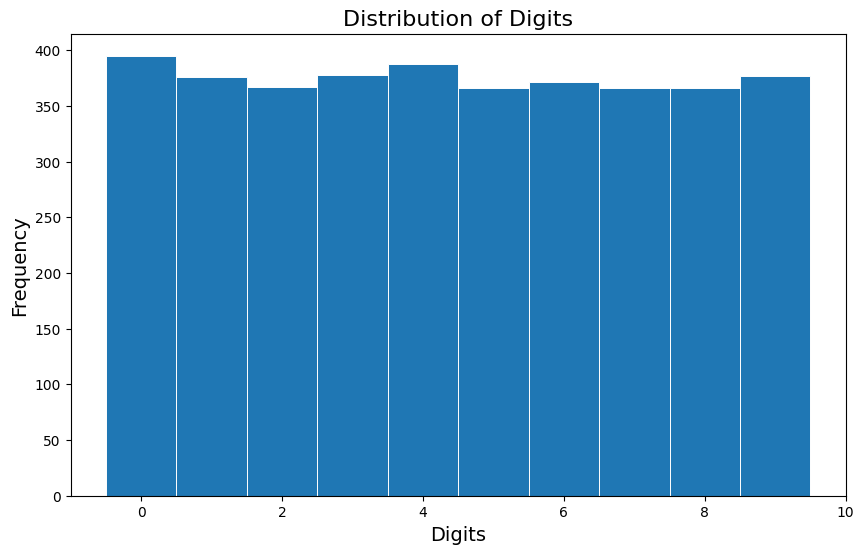

In [5]:
# Understanding the data distribution

digits, counts = np.unique(labeled_digits, return_counts=True)
fig, ax = plt.subplots(figsize=(10, 6)) 

ax.bar(digits, counts, width=1, edgecolor="white", linewidth=0.7)
ax.set_title('Distribution of Digits', fontsize=16)  
ax.set_xlabel('Digits', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14) 

# Observation: Equal distribution of classes (our classes are digits)

In [6]:
# This is an array containing the digit corresponding to each image:
labeled_digits[0:100]

array([1, 7, 0, 5, 2, 8, 4, 0, 4, 2, 2, 3, 4, 7, 2, 8, 0, 9, 2, 5, 4, 1,
       1, 6, 3, 6, 4, 9, 9, 7, 2, 4, 5, 1, 5, 7, 0, 4, 4, 6, 3, 0, 6, 5,
       0, 9, 7, 8, 0, 6, 1, 8, 4, 8, 9, 1, 4, 8, 0, 0, 7, 9, 1, 8, 9, 3,
       4, 9, 0, 5, 9, 6, 4, 0, 9, 4, 0, 6, 3, 1, 8, 9, 0, 8, 0, 1, 6, 4,
       4, 6, 1, 2, 7, 2, 0, 0, 5, 9, 2, 7])

### Logistic Classifier with Default Parameters

Documentation: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

pixel_size = labeled_images.shape[1] 
data_size = labeled_images.shape[0]

X = labeled_images.reshape(data_size, pixel_size * pixel_size)
y = labeled_digits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# SGDClassifier with loss='log_loss' is equivalent to logistic regression trained with SGD
# Default: max_iter = 1000
clf = SGDClassifier(loss='log_loss', random_state=0)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
accuracy = np.mean(y_pred == y_train)
print('Logistic Classifier - Accuracy on the training set:', accuracy)

y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print('Logistic Classifier - Accuracy on the test set:', accuracy)

Logistic Classifier - Accuracy on the training set: 0.9796666666666667
Logistic Classifier - Accuracy on the test set: 0.864


### Tuning Logictic Classifier with Grid Search 

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l2', 'l1'], # regularization type 
    'alpha': [0.0001, 0.001, 0.01], # regularization strength
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

clf = SGDClassifier(loss='log_loss', random_state=0)

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters for SGD Classifier:", grid_search.best_params_)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reache

Best parameters for SGD Classifier: {'alpha': 0.01, 'learning_rate': 'optimal', 'penalty': 'l1'}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [10]:
best_params = grid_search.best_params_
clf_best = SGDClassifier(loss='log_loss', random_state=0, **best_params)

clf_best.fit(X_train, y_train)
y_pred = clf_best.predict(X_train)
accuracy = np.mean(y_pred == y_train)
print('Logistic Classifier - Accuracy on the training set:', accuracy)

y_pred = clf_best.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print('Logistic Classifier - Accuracy on the test set:', accuracy)

Logistic Classifier - Accuracy on the training set: 0.9063333333333333
Logistic Classifier - Accuracy on the test set: 0.8693333333333333


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [12]:
param_grid_early_stopping = {
    'early_stopping': [True, False], 
    'n_iter_no_change': [3, 5, 10, 20]
}

clf = SGDClassifier(loss='log_loss', random_state=0, **best_params)

grid_search_early_stopping = GridSearchCV(clf, param_grid_early_stopping, cv=5)
grid_search_early_stopping.fit(X_train, y_train)

print("Best parameters for early stopping:", grid_search_early_stopping.best_params_)

best_params_early = grid_search_early_stopping.best_params_
clf_final = SGDClassifier(loss='log_loss', random_state=0, **best_params, **best_params_early)

clf_final.fit(X_train, y_train)
y_train_pred = clf_final.predict(X_train)
train_accuracy = np.mean(y_train_pred == y_train)
print('Logistic Classifier - Accuracy on the training set:', train_accuracy)

y_test_pred = clf_final.predict(X_test)
test_accuracy = np.mean(y_test_pred == y_test)
print('Logistic Classifier - Accuracy on the test set:', test_accuracy)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reache

Best parameters for early stopping: {'early_stopping': False, 'n_iter_no_change': 3}
Logistic Classifier - Accuracy on the training set: 0.9063333333333333
Logistic Classifier - Accuracy on the test set: 0.8693333333333333


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


### Training Curve for Logistic Classifier with Early Stopping

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pixel_size = labeled_images.shape[1] 
data_size = labeled_images.shape[0]

X = labeled_images.reshape(data_size, pixel_size * pixel_size)
y = labeled_digits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0) # Split further into validation dataset

max_iters = 1000  # default value
clf = SGDClassifier(loss='log_loss', max_iter=max_iters, tol=None, random_state=0, warm_start=True)

train_accs = []
val_accs = []

patience = 10
val_acc_best = 0
patience_cnt = 0

for epoch in range(max_iters):
    clf.fit(X_train, y_train)  # Incremental training for writing the training curve implementation

    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)

    train_acc = accuracy_score(y_train, y_train_pred) * 100
    val_acc = accuracy_score(y_val, y_val_pred) * 100

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Early stopping implementation
    if val_acc > val_acc_best:
        val_acc_best = val_acc
        patience_cnt = 0
    else:
        patience_cnt +=1
        if patience_cnt == patience:
            break

y_test_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Final Test Accuracy: {test_acc}')

# Plot the training curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy', linestyle='--', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Curve: Accuracy vs. Epochs')
plt.legend()
plt.grid()
plt.show()

KeyboardInterrupt: 

### Learning Curve for Logistic Classifier

Documentation: https://scikit-learn.org/1.5/auto_examples/model_selection/plot_learning_curve.html

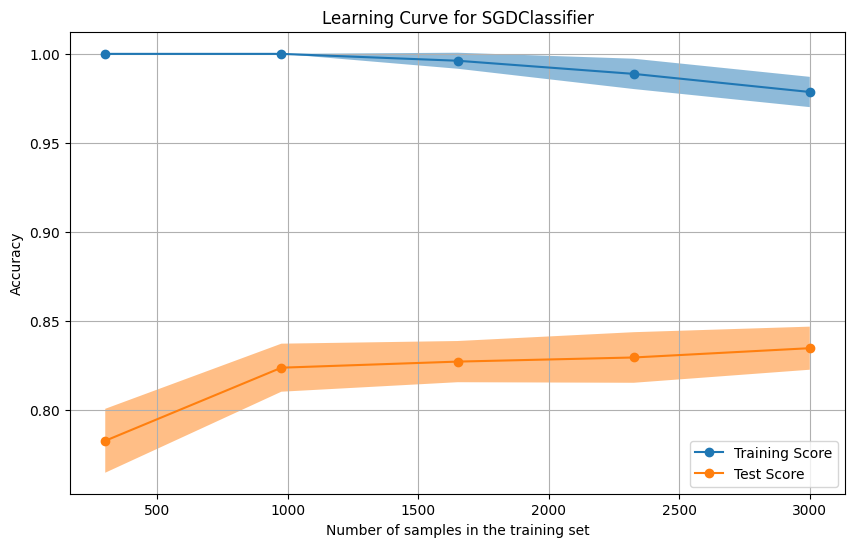

In [ ]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(figsize=(10, 6))

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(clf, **common_params, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {clf.__class__.__name__}")
ax.grid()
plt.show()

### Prepare autograder submission

In the autograder you will need to provide two things: 1) estimate of the accuracy of your model on unseen data, 2) the predictions on the autograder images. For the autograder images we only provide the images and not the class labels. Thus, you cannot compute the accuracy on this data yourself - you need to estimate that with labeled data that is provided (labeled_images, labeled_digits). We will calculate the accuracy for you on the autograder data and you will receive an automatic grade based on this. 

In [ ]:
estimate = np.array([0.8693]) # TODO Replace this with your estimate of the accuracy on new data
auto_processed = autograder_images.reshape(autograder_images.shape[0], -1)
prediction = clf_best.predict(auto_processed)
# For example using something like:
# prediction = my_super_duper_model.predict(autograder_images) 

result = np.append(estimate, prediction)

# The code below will write your estimate and prediction to a file named autograder.txt
# You will need to upload this file to the Vocareum autograder
pd.DataFrame(result).to_csv("autograder.txt", index=False, header=False)